
==== 2D SYMMETRY STRESS TEST REPORT (combined) ====
seed = 7
Nreal = 120
sigma_dn = 2.00e-06
sym_mode = pi
-----------------------------------------------
ε_sym (reference, no disorder) = 9.862e-15
⟨ε_sym⟩ (single-shot mean)     = 1.511
ε_sym (ensemble mean)          = 1.987e-01
-----------------------------------------------
⟨δn⟩ (mean over realizations)  = -7.590e-24
sym-bias of δn (mean)          = 2.258e-06


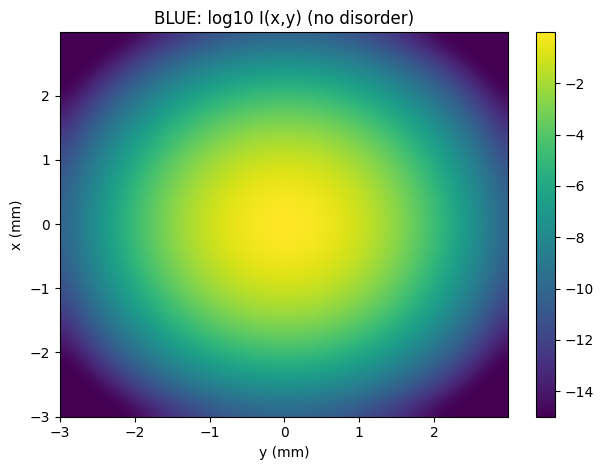

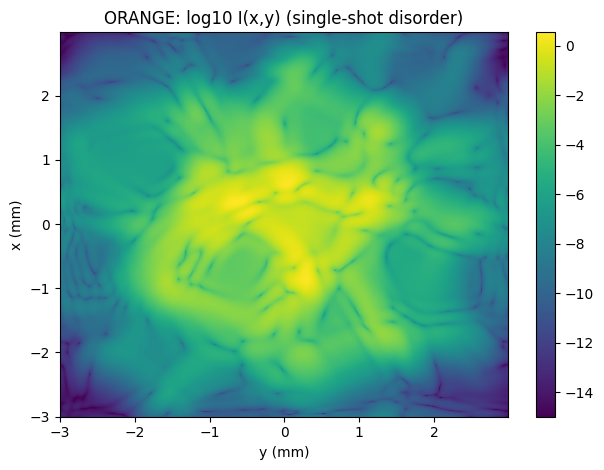

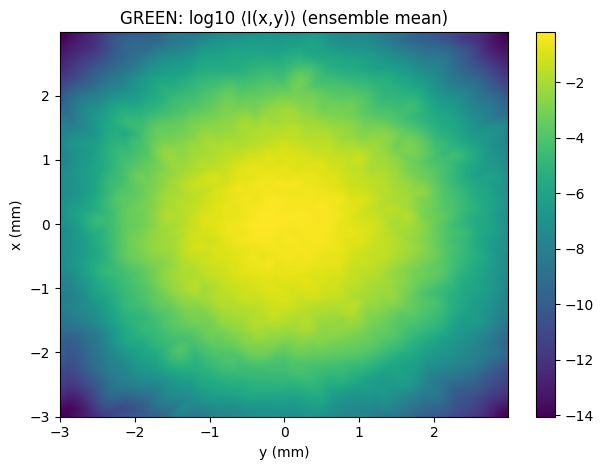

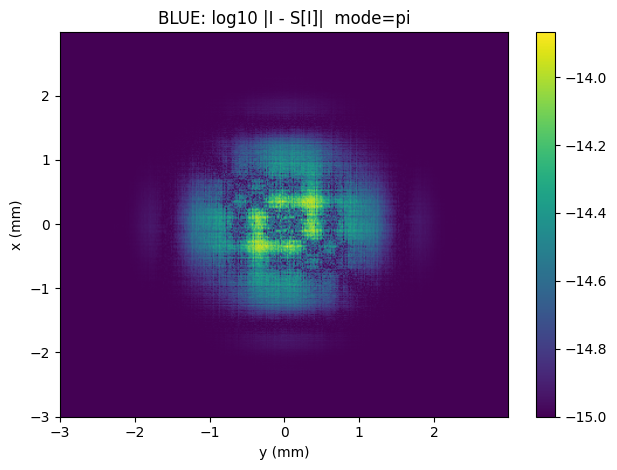

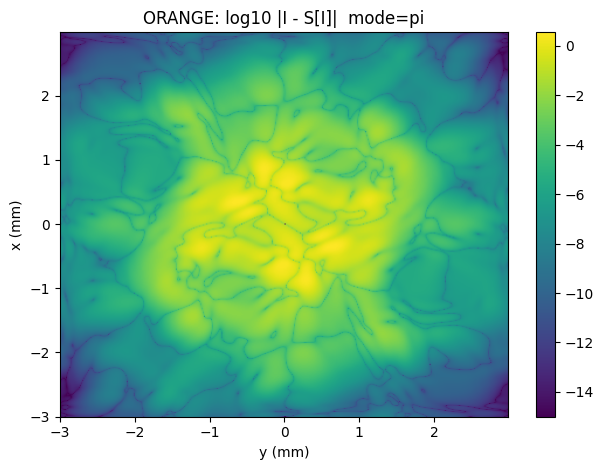

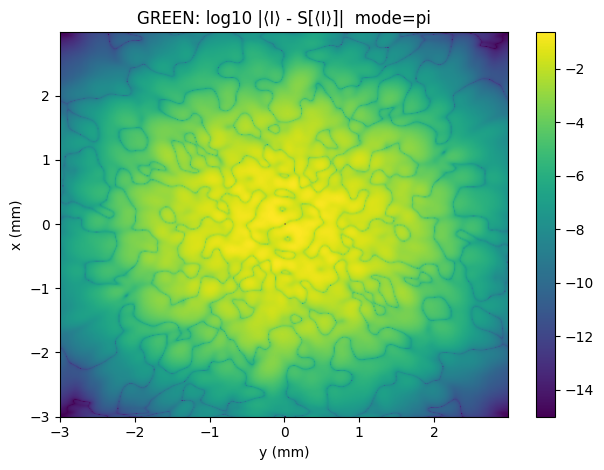

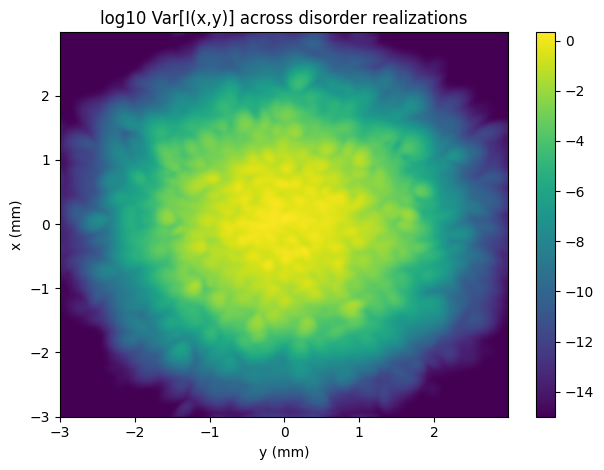

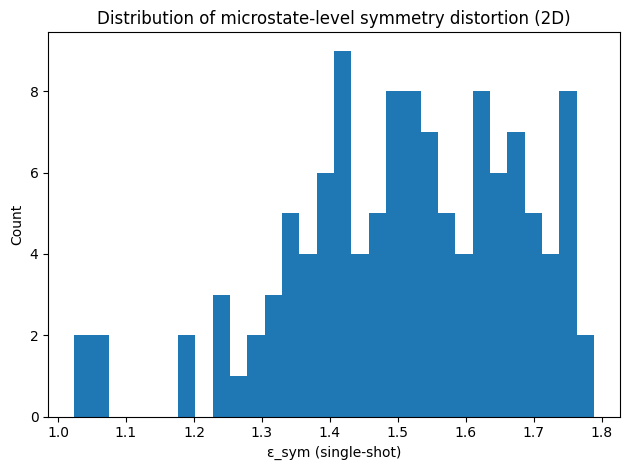

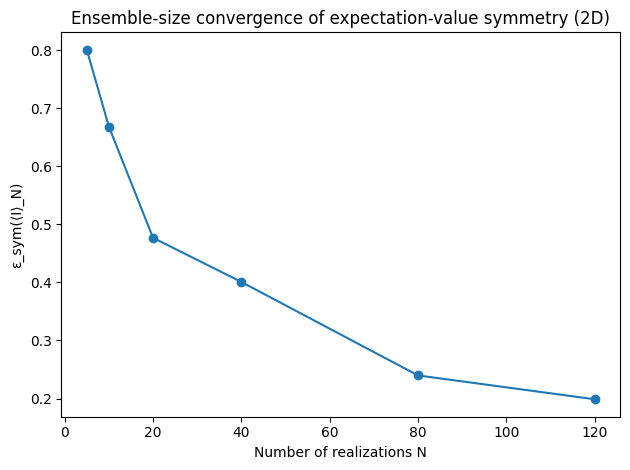


==== 2D SYMMETRY STRESS TEST REPORT (combined) ====
seed = 7
Nreal = 120
sigma_dn = 0.00e+00
sym_mode = pi
-----------------------------------------------
ε_sym (reference, no disorder) = 9.862e-15
⟨ε_sym⟩ (single-shot mean)     = 0.000
ε_sym (ensemble mean)          = 9.821e-15
-----------------------------------------------
⟨δn⟩ (mean over realizations)  = 0.000e+00
sym-bias of δn (mean)          = 0.000e+00

==== 2D SYMMETRY STRESS TEST REPORT (combined) ====
seed = 7
Nreal = 120
sigma_dn = 5.00e-07
sym_mode = pi
-----------------------------------------------
ε_sym (reference, no disorder) = 9.862e-15
⟨ε_sym⟩ (single-shot mean)     = 0.860
ε_sym (ensemble mean)          = 8.730e-02
-----------------------------------------------
⟨δn⟩ (mean over realizations)  = -1.898e-24
sym-bias of δn (mean)          = 5.646e-07

==== 2D SYMMETRY STRESS TEST REPORT (combined) ====
seed = 7
Nreal = 120
sigma_dn = 1.00e-06
sym_mode = pi
-----------------------------------------------
ε_sym (refere

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2D utilities
# ============================================================

def gaussian_beam_2d(X, Y, w0=0.6e-3, x0=0.0, y0=0.0, kx0=0.0, ky0=0.0):
    """Centered 2D Gaussian complex envelope E(x,y,z=0)."""
    return np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*w0**2)) * np.exp(1j*(kx0*X + ky0*Y))

def correlated_noise_2d(nx, ny, dx, dy, corr_len, rng):
    """
    Zero-mean, unit-std correlated Gaussian noise in 2D via spectral shaping:
    filter(k) ~ exp(-(k*corr_len)^2/2) with k^2 = kx^2 + ky^2
    """
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    white = rng.normal(size=(nx, ny)) + 1j*rng.normal(size=(nx, ny))
    filt = np.exp(-0.5 * K2 * (corr_len**2))

    noise = np.fft.ifft2(white * filt).real
    noise -= noise.mean()
    noise /= (noise.std() + 1e-15)
    return noise

def split_step_2d(E0, dx, dy, dz, nsteps, k0, delta_n):
    """
    Split-step Fourier for 2D paraxial equation:
      i dE/dz = -(1/(2k0)) (d2E/dx2 + d2E/dy2) + k0*delta_n(x,y)*E
    """
    nx, ny = E0.shape
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    V = k0 * delta_n
    expV = np.exp(-1j * V * dz/2.0)
    expD = np.exp(-1j * K2 * dz/(2.0*k0))

    E = E0.astype(np.complex128).copy()
    for _ in range(nsteps):
        E = expV * E
        Ek = np.fft.fft2(E)
        Ek *= expD
        E = np.fft.ifft2(Ek)
        E = expV * E
    return E

# ============================================================
# Correct discrete symmetry operators via index mapping
# Works for even/odd N with endpoint=False grids.
# Mapping corresponds to x_i -> -x_i => i -> (-i) mod N
# ============================================================

def _neg_index_map(N):
    return (-np.arange(N)) % N

def apply_symmetry(I, mode="pi"):
    """
    Apply discrete symmetry operator S to I using exact index mapping:
      mode="pi": (x,y)->(-x,-y)
      mode="x" : (x,y)->(-x, y)
      mode="y" : (x,y)->( x,-y)
    """
    nx, ny = I.shape
    ix = _neg_index_map(nx)
    iy = _neg_index_map(ny)

    if mode == "x":
        return I[np.ix_(ix, np.arange(ny))]
    if mode == "y":
        return I[np.ix_(np.arange(nx), iy)]
    # default: pi rotation
    return I[np.ix_(ix, iy)]

def eps_sym(I, mode="pi"):
    J = apply_symmetry(I, mode=mode)
    return np.sum(np.abs(I - J)) / (np.sum(I) + 1e-15)

def diff_map(I, mode="pi"):
    return np.abs(I - apply_symmetry(I, mode=mode))

# ============================================================
# Main 2D stress test
# ============================================================

def run_stress_test_2d(
    seed=7,
    Nreal=120,
    lam=800e-9,
    Lx=6e-3,
    Ly=6e-3,
    Nx=384,
    Ny=384,
    z_total=0.4,
    dz=2e-3,
    corr_len=0.25e-3,
    sigma_dn=2e-6,
    w0=0.6e-3,
    sym_mode="pi",   # "pi", "x", or "y"
    do_plots=True
):
    rng = np.random.default_rng(seed)

    x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    X, Y = np.meshgrid(x, y, indexing='ij')

    k0 = 2*np.pi/lam
    nsteps = int(z_total/dz)

    # symmetric baseline input
    E0 = gaussian_beam_2d(X, Y, w0=w0)

    # BLUE reference: no disorder
    dn0 = np.zeros((Nx, Ny))
    E_ref = split_step_2d(E0, dx, dy, dz, nsteps, k0, dn0)
    I_ref = np.abs(E_ref)**2
    eps_ref = eps_sym(I_ref, mode=sym_mode)
    diff_ref = diff_map(I_ref, mode=sym_mode)

    # ORANGE microstates
    I_all = np.zeros((Nreal, Nx, Ny), dtype=np.float64)
    eps_single = np.zeros(Nreal, dtype=np.float64)

    dn_means = []
    dn_sym_bias = []  # symmetry bias in disorder (should scale with sigma_dn, but no preferred sign)

    for r in range(Nreal):
        dn_raw = correlated_noise_2d(Nx, Ny, dx, dy, corr_len, rng)
        delta_n = sigma_dn * dn_raw

        dn_means.append(delta_n.mean())
        dn_sym_bias.append(np.mean(np.abs(delta_n - apply_symmetry(delta_n, mode=sym_mode))))

        E = split_step_2d(E0, dx, dy, dz, nsteps, k0, delta_n)
        I = np.abs(E)**2
        I_all[r] = I
        eps_single[r] = eps_sym(I, mode=sym_mode)

    # GREEN expectation value
    I_mean = I_all.mean(axis=0)
    eps_ens = eps_sym(I_mean, mode=sym_mode)
    diff_mean = diff_map(I_mean, mode=sym_mode)

    # Variance map
    I_var = I_all.var(axis=0)

    # Convergence vs N
    Ns = np.array([5, 10, 20, 40, 80, Nreal])
    eps_conv = []
    for N in Ns:
        eps_conv.append(eps_sym(I_all[:N].mean(axis=0), mode=sym_mode))
    eps_conv = np.array(eps_conv)

    # Representative single-shot (median eps)
    idx_med = np.argsort(eps_single)[len(eps_single)//2]
    I_med = I_all[idx_med]
    diff_med = diff_map(I_med, mode=sym_mode)

    # Report
    print("\n==== 2D SYMMETRY STRESS TEST REPORT (combined) ====")
    print(f"seed = {seed}")
    print(f"Nreal = {Nreal}")
    print(f"sigma_dn = {sigma_dn:.2e}")
    print(f"sym_mode = {sym_mode}")
    print("-----------------------------------------------")
    print(f"ε_sym (reference, no disorder) = {eps_ref:.3e}")
    print(f"⟨ε_sym⟩ (single-shot mean)     = {eps_single.mean():.3f}")
    print(f"ε_sym (ensemble mean)          = {eps_ens:.3e}")
    print("-----------------------------------------------")
    print(f"⟨δn⟩ (mean over realizations)  = {np.mean(dn_means):.3e}")
    print(f"sym-bias of δn (mean)          = {np.mean(dn_sym_bias):.3e}")

    if not do_plots:
        return {
            "x": x, "y": y,
            "I_ref": I_ref, "I_med": I_med, "I_mean": I_mean,
            "diff_ref": diff_ref, "diff_med": diff_med, "diff_mean": diff_mean,
            "I_var": I_var,
            "eps_ref": eps_ref,
            "eps_single": eps_single,
            "eps_ens": eps_ens,
            "Ns": Ns, "eps_conv": eps_conv
        }

    # ============================================================
    # Plots
    # ============================================================

    extent = [y[0]*1e3, y[-1]*1e3, x[0]*1e3, x[-1]*1e3]  # y horizontal, x vertical

    def show_field(field, title, log=False):
        plt.figure()
        plot_field = np.log10(field + 1e-15) if log else field
        plt.imshow(plot_field, origin="lower", aspect="auto", extent=extent)
        plt.xlabel("y (mm)")
        plt.ylabel("x (mm)")
        plt.title(title)
        plt.colorbar()
        plt.tight_layout()

    # Intensity maps
    show_field(I_ref,  "BLUE: log10 I(x,y) (no disorder)", log=True)
    show_field(I_med,  "ORANGE: log10 I(x,y) (single-shot disorder)", log=True)
    show_field(I_mean, "GREEN: log10 ⟨I(x,y)⟩ (ensemble mean)", log=True)

    # Symmetry difference maps
    show_field(diff_ref,  f"BLUE: log10 |I - S[I]|  mode={sym_mode}", log=True)
    show_field(diff_med,  f"ORANGE: log10 |I - S[I]|  mode={sym_mode}", log=True)
    show_field(diff_mean, f"GREEN: log10 |⟨I⟩ - S[⟨I⟩]|  mode={sym_mode}", log=True)

    # Variance map
    show_field(I_var, "log10 Var[I(x,y)] across disorder realizations", log=True)

    # Histogram of single-shot eps
    plt.figure()
    plt.hist(eps_single, bins=30)
    plt.xlabel("ε_sym (single-shot)")
    plt.ylabel("Count")
    plt.title("Distribution of microstate-level symmetry distortion (2D)")
    plt.tight_layout()

    # Convergence vs N
    plt.figure()
    plt.plot(Ns, eps_conv, marker="o")
    plt.xlabel("Number of realizations N")
    plt.ylabel("ε_sym(⟨I⟩_N)")
    plt.title("Ensemble-size convergence of expectation-value symmetry (2D)")
    plt.tight_layout()

    plt.show()

    return {
        "x": x, "y": y,
        "I_ref": I_ref, "I_med": I_med, "I_mean": I_mean,
        "diff_ref": diff_ref, "diff_med": diff_med, "diff_mean": diff_mean,
        "I_var": I_var,
        "eps_ref": eps_ref,
        "eps_single": eps_single,
        "eps_ens": eps_ens,
        "Ns": Ns, "eps_conv": eps_conv
    }

# ============================================================
# Optional sweep disorder strength in 2D
# ============================================================

def sweep_sigma_2d(sigmas, seed=7, **kwargs):
    eps_single_mean = []
    eps_ens = []
    for s in sigmas:
        out = run_stress_test_2d(seed=seed, sigma_dn=s, do_plots=False, **kwargs)
        eps_single_mean.append(out["eps_single"].mean())
        eps_ens.append(out["eps_ens"])

    plt.figure()
    plt.plot(sigmas, eps_single_mean, marker='o', label="single-shot mean ⟨ε_sym⟩")
    plt.plot(sigmas, eps_ens, marker='o', label="ensemble ε_sym(⟨I⟩)")
    plt.xlabel("σ_dn")
    plt.ylabel("ε_sym")
    plt.title("2D: Fragility of microstate symmetry vs robustness of expectation symmetry")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_stress_test_2d(sym_mode="pi", do_plots=True)
    sweep_sigma_2d([0.0, 0.5e-6, 1e-6, 2e-6, 4e-6],
                   seed=7,
                   Nreal=120,
                   Nx=384, Ny=384,
                   Lx=6e-3, Ly=6e-3,
                   z_total=0.4, dz=2e-3,
                   corr_len=0.25e-3,
                   w0=0.6e-3,
                   sym_mode="pi")

